### RNN using Froen Dessert Dataset

Importing the Libraries

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 

In [2]:
df = pd.read_csv('Frozen_Dessert_Production.csv',index_col='DATE',parse_dates=True)
df.head()

,IPN31152N
DATE,
1972-01-01,59.9622
1972-02-01,67.0605
1972-03-01,74.2350
1972-04-01,78.1120
1972-05-01,84.7636


In [3]:
df.columns = ['Production']
df.head()

,Production
DATE,
1972-01-01,59.9622
1972-02-01,67.0605
1972-03-01,74.2350
1972-04-01,78.1120
1972-05-01,84.7636


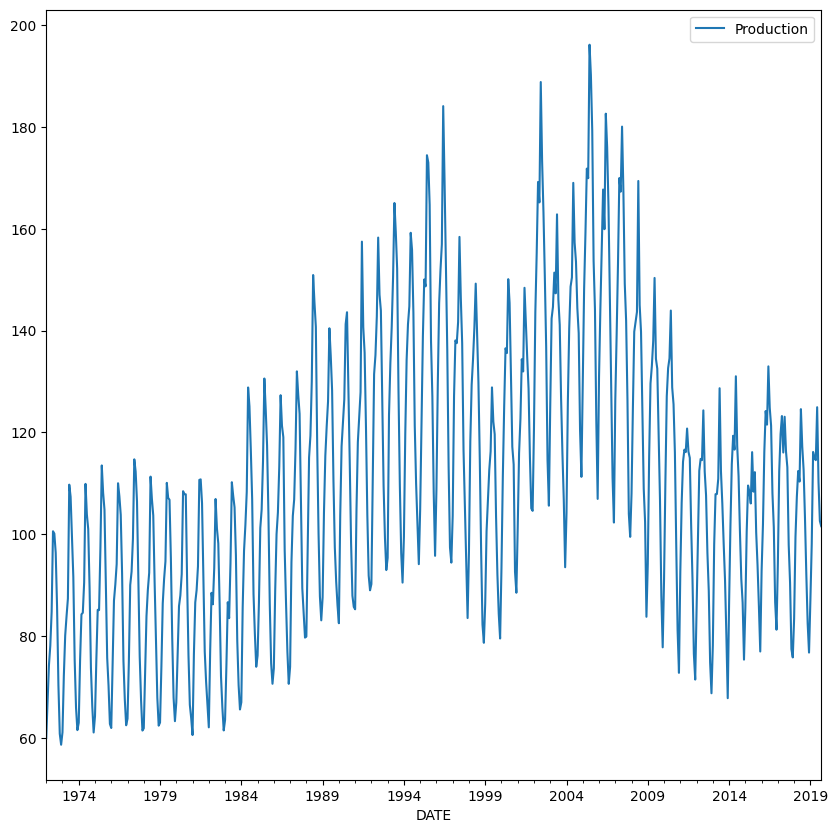

In [4]:
df.plot(figsize=(10,10));

Splitting the Data

In [5]:
test_size = 24
test_ind = len(df)- test_size
train = df.iloc[:test_ind]
test = df.iloc[test_ind:]

In [7]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [8]:
scaler.fit(train)

MinMaxScaler()

In [9]:
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

Time Series Generator

In [11]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
length = 18
n_features=1
generator = TimeseriesGenerator(scaled_train, scaled_train, length=length, batch_size=1)

## Building the model

In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM
from tensorflow.keras.callbacks import EarlyStopping

In [13]:
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(length, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               40800     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 40901 (159.77 KB)
Trainable params: 40901 (159.77 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [15]:
validation_generator = TimeseriesGenerator(scaled_test,scaled_test, length=length, batch_size=1)

In [17]:
early_stop = EarlyStopping(monitor='loss',patience=2, mode='min')

Training

In [18]:
model.fit_generator(generator,epochs=20,
                    validation_data=validation_generator,
                   callbacks=[early_stop])

Epoch 1/20


/var/folders/c8/6w2372kx4cqg___pmmln1q4h0000gn/T/ipykernel_45257/3502985036.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(generator,epochs=20,


531/531 [==============================] - 2s 3ms/step - loss: 0.0287 - val_loss: 0.0045
Epoch 2/20
531/531 [==============================] - 1s 3ms/step - loss: 0.0103 - val_loss: 0.0023
Epoch 3/20
531/531 [==============================] - 1s 3ms/step - loss: 0.0047 - val_loss: 0.0017
Epoch 4/20
531/531 [==============================] - 1s 3ms/step - loss: 0.0038 - val_loss: 0.0018
Epoch 5/20
531/531 [==============================] - 1s 3ms/step - loss: 0.0035 - val_loss: 0.0023
Epoch 6/20
531/531 [==============================] - 2s 3ms/step - loss: 0.0029 - val_loss: 0.0021
Epoch 7/20
531/531 [==============================] - 1s 3ms/step - loss: 0.0031 - val_loss: 0.0024
Epoch 8/20
531/531 [==============================] - 1s 3ms/step - loss: 0.0029 - val_loss: 0.0032
Epoch 9/20
531/531 [==============================] - 1s 3ms/step - loss: 0.0029 - val_loss: 0.0067
Epoch 10/20
531/531 [==============================] - 1s 3ms/step - loss: 0.0028 - val_loss: 0.0025
Epoch 11/2

## Visualization

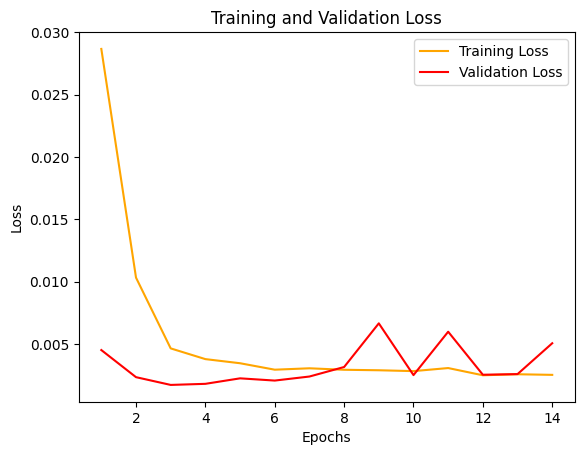

In [23]:
# Accessing loss and validation loss from model history
loss = model.history.history['loss']
val_loss = model.history.history['val_loss']

# Plotting loss and validation loss with different colors (green and purple)
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'orange', label='Training Loss')  
plt.plot(epochs, val_loss, 'red', label='Validation Loss')  
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


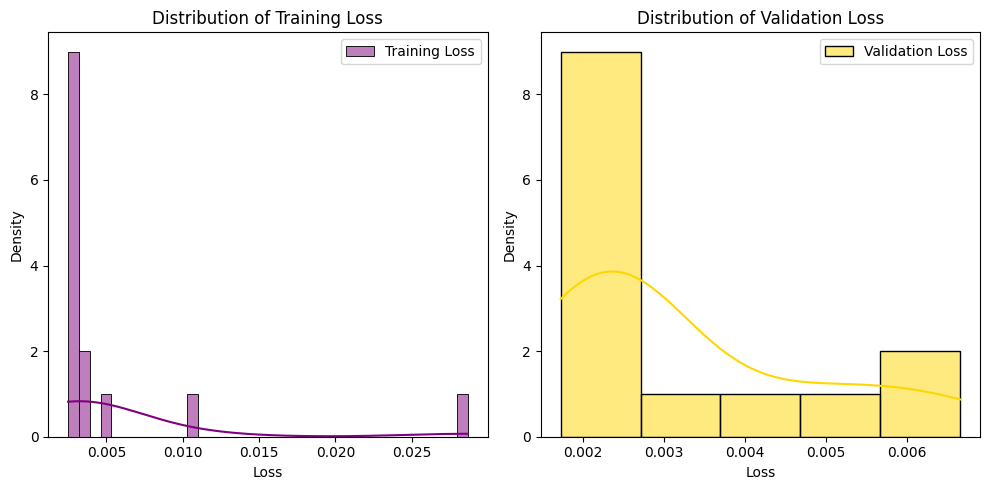

In [21]:
import seaborn as sns

# Accessing loss and validation loss from model history
loss_values = model.history.history['loss']
val_loss_values = model.history.history['val_loss']

# Creating separate plots for training loss and validation loss
plt.figure(figsize=(10, 5))  # Adjust figure size if needed

plt.subplot(1, 2, 1)  # Subplot for training loss
sns.histplot(loss_values, color='purple', label='Training Loss', kde=True)
plt.title('Distribution of Training Loss')
plt.xlabel('Loss')
plt.ylabel('Density')
plt.legend()

plt.subplot(1, 2, 2)  # Subplot for validation loss
sns.histplot(val_loss_values, color='gold', label='Validation Loss', kde=True)
plt.title('Distribution of Validation Loss')
plt.xlabel('Loss')
plt.ylabel('Density')
plt.legend()

plt.tight_layout()  # Adjust spacing between subplots
plt.show()


## Evalutaion

In [24]:
test_predictions = []

first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(len(test)):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    test_predictions.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

1/1 [==============================] - 0s 9ms/step


In [25]:
true_predictions = scaler.inverse_transform(test_predictions)
test['Predictions'] = true_predictions

/var/folders/c8/6w2372kx4cqg___pmmln1q4h0000gn/T/ipykernel_45257/4268826688.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions'] = true_predictions


In [26]:
test

,Production,Predictions
DATE,,
2017-10-01,90.4732,91.502302
2017-11-01,77.4378,85.508013
2017-12-01,75.8118,86.408911
2018-01-01,83.4343,101.053063
2018-02-01,99.4899,115.091243
2018-03-01,107.3152,125.335212
2018-04-01,112.4309,133.435440
2018-05-01,110.3544,138.784488
2018-06-01,124.5841,139.421247


Visualizing

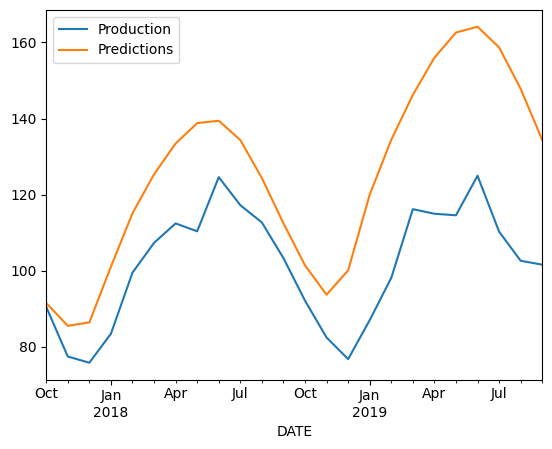

In [30]:
test.plot();

Root Mean Squared Error

In [31]:
from sklearn.metrics import mean_squared_error
np.sqrt(mean_squared_error(test['Production'],test['Predictions']))

27.456663592052973